<a href="https://colab.research.google.com/github/helgadenes/Astrophysics_yachay/blob/main/python_tutorials/ISM_tutorial/Dust_and_gas_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dust and gas maps

Documentation on dust maps: https://dustmaps.readthedocs.io/en/latest/installation.html

More info on dust maps: http://argonaut.skymaps.info/usage

This tutorial
- gets E(B-V) from dust maps
- converts E(B-V) to $A_V$
- plots the dust maps
- downloads a neutral hydrogen column density map for the same region N(HI)
- compares the two data sets.

Documentation on skyview: https://astroquery.readthedocs.io/en/latest/skyview/skyview.html


In [1]:
# astroquery and dustmaps are not a default package in google colab
!pip install astroquery
!pip install dustmaps

## Plotting maps

Dustmaps provides a unified interface for several 2D and 3D maps of interstellar dust reddening and extinction.

Documentation on how to use dust maps:
https://dustmaps.readthedocs.io/en/latest/examples.html

## Doing a Web based Query to get dust maps

In [6]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# astropy libraries
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.skyview import SkyView
from astropy.wcs import WCS

# dustmaps libraries
from dustmaps.sfd import SFDWebQuery
from dustmaps.bayestar import BayestarWebQuery

In [8]:
# test query for a single coordinate

coords = SkyCoord(119.*u.deg, 3.*u.deg, distance=1000.*u.pc, frame='galactic')

bayestar_0 = BayestarWebQuery()

Av_bayesta_0 = 2.742 * bayestar_0(coords)

print('Av from Baystar dust map:', Av_bayesta_0)

Av from Baystar dust map: 4.0581600522995


In [9]:
# the edge of the Aql south molecular cloud

c_g = SkyCoord(l=37 * u.degree, b=-30 * u.degree, frame='galactic')
c_g.icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (311.56294677, -9.98052695)>

In [35]:
# let's define a square region for the dust map

ra0, dec0 = (302., -5.)
ra = np.arange(ra0 - 4., ra0 + 4., 0.05)
dec = np.arange(dec0 - 4., dec0 + 4., 0.05)
ra, dec = np.meshgrid(ra, dec)
coords = SkyCoord(ra * u.deg, dec * u.deg, distance=1. * u.kpc, frame='icrs')

In [24]:
# downloading 2 different maps for the same region of the sky
# and converting the E(B-V) reddening to A_v extinction

sfd = SFDWebQuery()

# convert E(B-V) to A_v
Av_sfd = 2.742 * sfd(coords)

bayestar = BayestarWebQuery()

# convert E(B-V) to A_v
Av_bayestar = 2.742 * bayestar(coords)

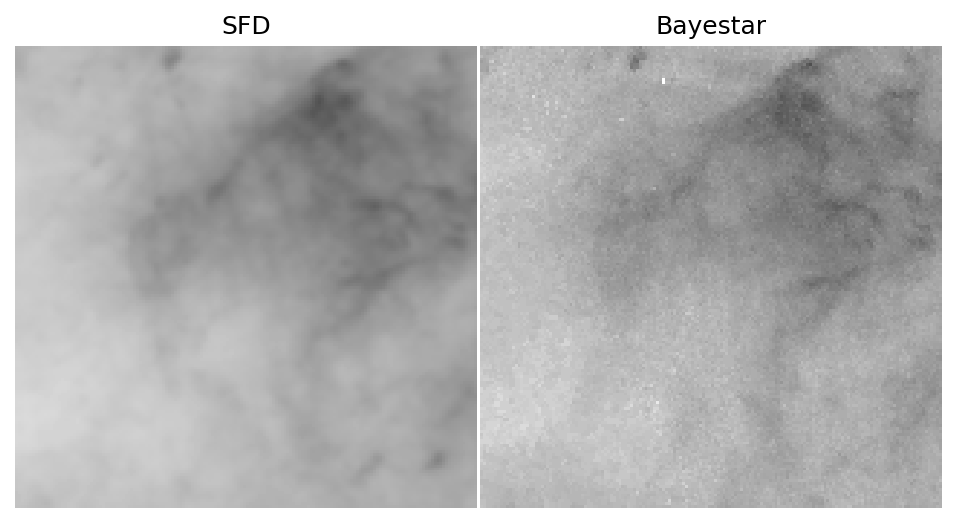

In [25]:
# plotting the two maps that we downloaded

fig = plt.figure(figsize=(12,4), dpi=150)

for k,(Av,title) in enumerate([(Av_sfd, 'SFD'),
                               (Av_bayestar, 'Bayestar')]):
    ax = fig.add_subplot(1,3,k+1)
    ax.imshow(
        np.sqrt(Av)[::,::-1],
        vmin=0.,
        vmax=2.,
        origin='lower',
        interpolation='nearest',
        cmap='binary',
        aspect='equal'
    )
    ax.axis('off')
    ax.set_title(title)

fig.subplots_adjust(wspace=0., hspace=0.)
plt.savefig('comparison.png', dpi=150)

**Which dust maps looks higher resolution?**

In [26]:
Av.shape

(160, 160)

## HI column denisty map

We want to compare the dust maps with HI column denisty maps. For this, we need to download HI data.

Currently, the best data set available for the whole sky is HI4PI, which is available from Skyview. SkyView is a multi-wavelength data base: https://skyview.gsfc.nasa.gov/current/cgi/titlepage.pl You can downolad optical, infrared, UV, radio, etc. images from

SkyView. SkyView also has a python interface: https://astroquery.readthedocs.io/en/latest/skyview/skyview.html (This website lists all the available data sets.)


Important, **you need to make sure to download the HI data at the same coordinates with the same pixel resolution as the dust maps data!** The dust maps do not have metadata.

In [36]:
# get HI column denisty map for the same region of the sky

c = SkyCoord(ra=302 * u.degree, dec=-5 * u.degree, frame='icrs')

path = SkyView.get_images(position=c, width=8*u.deg, height=8*u.deg, survey=['HI4PI'], pixels=[160,160])

hdulist_HI = path[0]
d_HI = hdulist_HI[0].data
h_HI = hdulist_HI[0].header

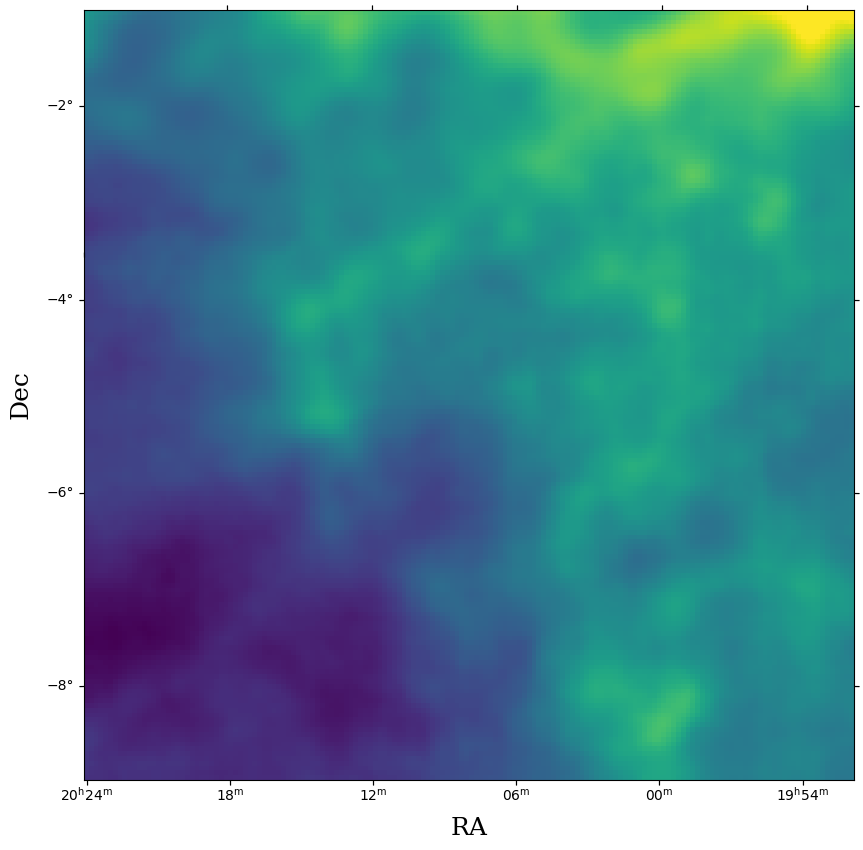

In [29]:
# Let's plot the HI data

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1, projection=WCS(h_HI))
ax.imshow(d_HI, vmax=np.percentile(d_HI, 99.8))
ax.set_xlabel('RA', size=18,family='serif')
ax.set_ylabel('Dec', size=18,family='serif')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()

## Compare the dust and the gas data

The two data sets should show a liner correlation. The more dust we have in a region, the more N(HI) we expect.

Note, it is importnat to match the two 2D arrays. To check that the two arrays are aligned, we will plot the images and make an overlay.

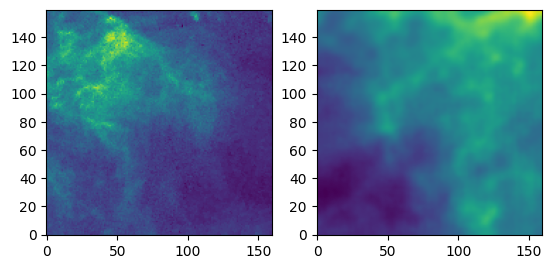

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plt.imshow(Av)
ax1.invert_yaxis()

ax2 = fig.add_subplot(1,2,2)
plt.imshow(d_HI)
ax2.invert_yaxis()

plt.show()

**Does this look right?**

The orientation of the two images does not match!

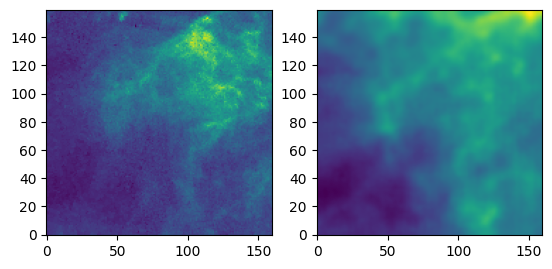

In [31]:
# lets make the two images match. We need to reverse the RA direction for the dust map

Av2 = Av[:, ::-1]

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plt.imshow(Av2)
ax1.invert_yaxis()

ax2 = fig.add_subplot(1,2,2)
plt.imshow(d_HI)
ax2.invert_yaxis()

plt.show()

**Do the maps look the same now?**

**What could be the reason for differences?**

### Lets make a better comparison with an overlay of the dust map with N(HI) contours

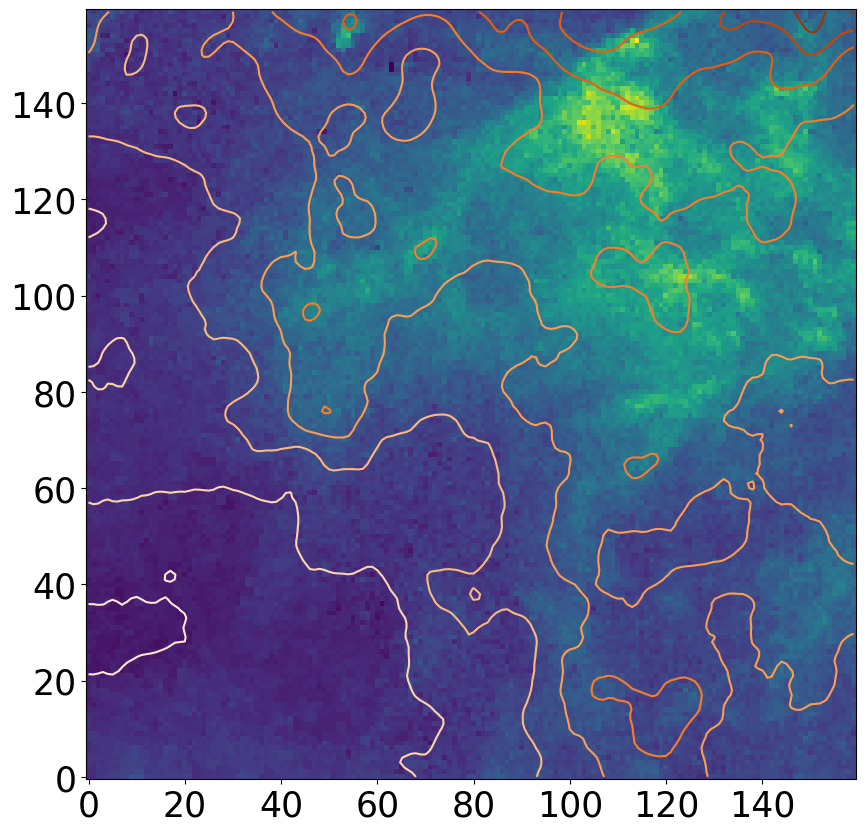

In [32]:
# making an overlay

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(Av2)
ax.contour(d_HI, levels=10, cmap='Oranges')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
ax.invert_yaxis()
plt.show()

**How is the match between the two datasets?**

### Comparing the E(B-V) to the N(HI) data

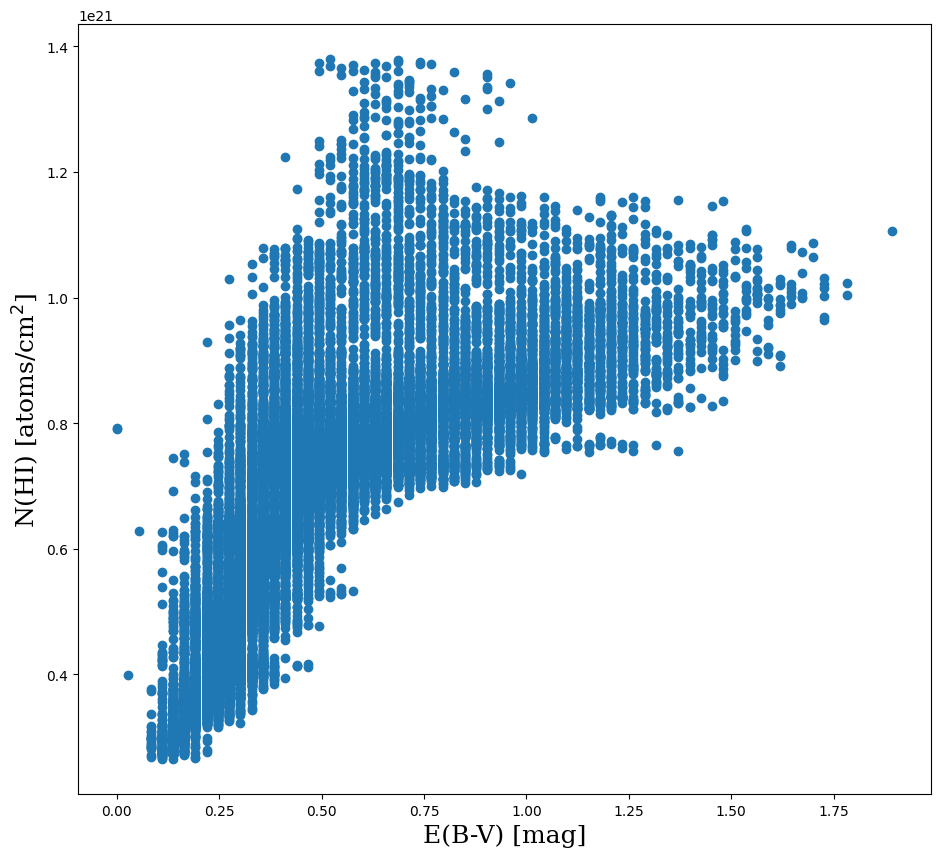

In [33]:
# directly compare the E(B-V) to N(HI) in each pixel

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1)
plt.scatter(Av2, d_HI)
ax.set_xlabel('E(B-V) [mag]', size=18,family='serif')
ax.set_ylabel(r'N(HI) [atoms/cm$^2$]', size=18,family='serif')
plt.show()

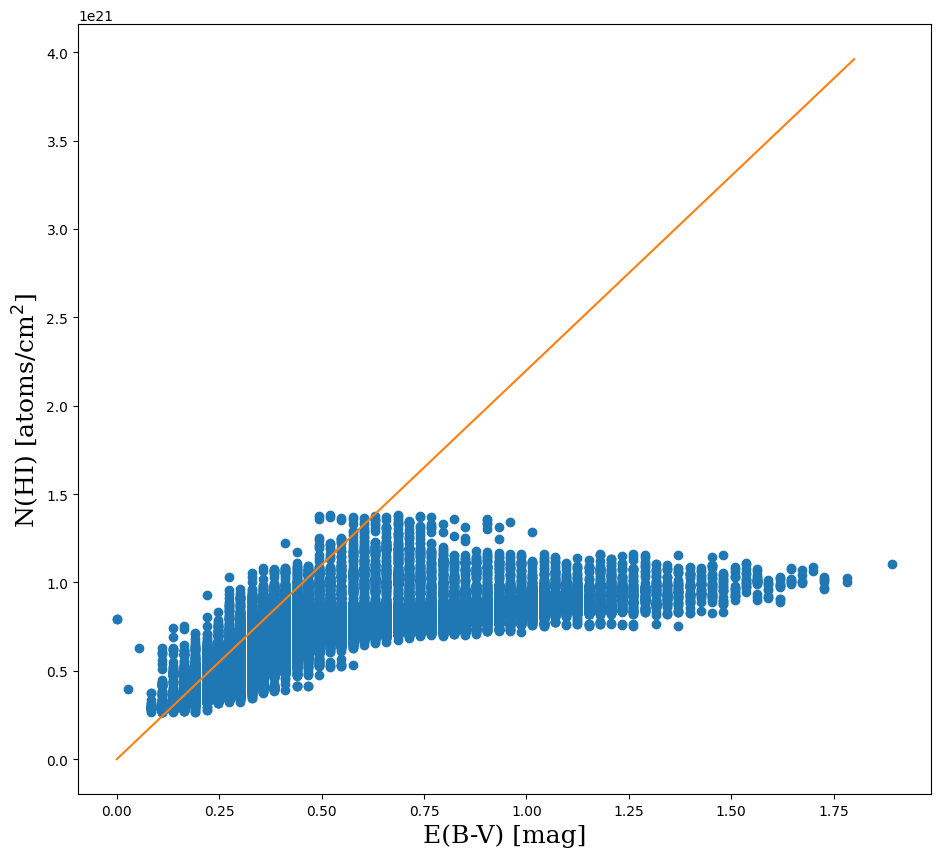

In [34]:
# lets add a model from a scientic paper
# relation from Güver and Özel 2009 (doi:10.1111/j.1365-2966.2009.15598.x)

ebv_range = np.arange(np.min(Av), np.max(Av), 0.1)
line = ebv_range * 2.2 * 10**21

fig = plt.figure(figsize=(11,10))
ax = fig.add_subplot(1,1,1)
plt.scatter(Av2, d_HI)
plt.plot(ebv_range, line, color='C1')
ax.set_xlabel('E(B-V) [mag]', size=18,family='serif')
ax.set_ylabel(r'N(HI) [atoms/cm$^2$]', size=18,family='serif')
plt.show()

The model seems to fit the data at small E(B-V) but not at higher values. Where the HI column density becomes less then expected.

## What is the reason of the discrepancy?